<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2019 </h1>
<H3 align='center'> Gonzalo Larrain - Nicolas Pino </H3>
<H3 align='center'> 201673516-K - 201673534-8 </H3>
<H3 align='center'> Tarea 3 - Ensamblados y modelos avanzados </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Técnicas de ensamblado: *bagging*, *boosting* y *random forest*.
* Ventajas de técnicas de ensamblados
* Problemas desbalanceados
 

**Formalidades**  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y cierre competencia: 17 de Enero
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF393-II-2019]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Ensamblados para regresión  
[2.](#segundo) Detección de acoso en *Twitter*  

In [0]:
import pandas as pd
df = pd.read_csv("DailyDelhiClimateTrain.csv")

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row

...#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
...#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
... #any more information?
df.drop(["date"], axis=1, inplace=True) #delete date


y = df.pop("y_value").values
X = df.values 
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only

a) Describa el problema trabajado, la cantida de datos que se cuenta como las características a trabajar. Al ser datos temporales podría ayudar una ilustración gráfica de la secuencias trabajadas y su comportamiento ¿Es válido el uso de la información sólo del día anterior?.

Se desea predecir la temperatura media para el día siguiente a partir de datos relevantes del clima como humedad del ambiente, rapidez del viento, presión media, entre otros. La muestra de datos para entrenamiento consiste de mediciones diarias durante un periodo de 4 años. Si bien regularmente se observa similitud entre el estado del clima de dos dias consecutivos, se obtendría mayor certeza de predicción al examinar periodos más extensos. Por ejemplo, en verano el clima mantiene características similares durante meses. Al predecir la temperatura del próximo 20 de enero, considerar las condiciones climáticas de enero en los años anteriores dará mayor certeza a la estimación que solo usar el día 19 como referencia.

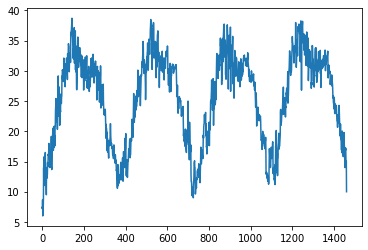

In [0]:
import matplotlib.pyplot as plt
plt.plot(y)

El gráfico muestra la temperatura media registrada durante aproximadamente 1460 días. Se observa el comportamiento cíclico del clima: temperaturas más bajas durante los primeros meses del año que se elevan hacia el fin del primer semestre. Finalmente el clima se vuelve más templado y progresivamente frío rumbo al mes de enero del siguiente año.

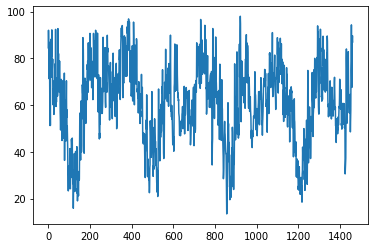

In [0]:
plt.plot(df['humidity'])


El comportamiento de la humedad no obedece a un patrón tan uniforme como el de la temperatura media. No obstante se observan descensos y alzas de humedad en periodos simétricos del año. Por ejemplo, se observa un alza en la humedad en los días cercanos al comienzo de un nuevo año (0,356,712,etc).

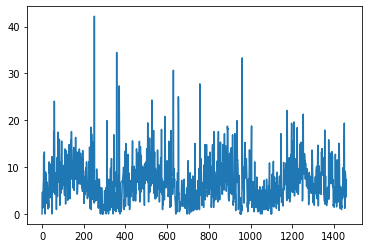

In [0]:
plt.plot(df['wind_speed'])

La rapidez del viento sigue una tendencia similar a la de la temperaturta media. Su tasa de cambio y su valor medio son menores, pero su aumento y descenso imitan a los de la temperatura media.

In [0]:
import numpy as np
def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )
from sklearn.tree import DecisionTreeRegressor as Tree
model_unr = Tree() #unregularized model -- default parameters
model_unr.fit(X_train,y_train)
... #define your regularized tree model

Ellipsis

b) Entrene un solo Árbol de Regresión de múltiples niveles para resolver el problema. Defina un Árbol no regularizado (como el que no tiene límites en su profundidad) y otro Árbol regularizado (variando los hiper-parámetros que prefiera, por ejemplo, los más comunes como la profundidad, el número mínimo de datos para realizar split o el número mínimo de datos en cada hoja). Además comente sobre la ventaja de usar un árbol de decisión respecto a la escala de los datos ¿Porqué no es necesario escalar los datos?

In [0]:
import numpy as np
def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )
from sklearn.tree import DecisionTreeRegressor as Tree
model_unr = Tree() 
y_train_hat = model_unr.fit(X_train,y_train)

profundidad = np.arange(1, X_train.shape[1], 2 ) 
sample = np.arange(2, X_train.shape[0] , 200 ) 

models = []

for d in profundidad:
    for s in sample:
        model_reg = Tree()
        model_reg.set_params(max_depth = d, min_samples_split = s)
        model_reg.fit(X_train,y_train)
        models.append(model_reg)
        


c) Para evaluar la calidad de predicción en este problema se utilizará la métrica Root Mean Squared Error (RMSE), indicando un error en la escala real de la temperatura. Como los datos de validación siguen con el orden temporal, visualice esa predicción a lo largo del tiempo. Comente sobre los resultados comparando la regularización vs el no regularizar.

RMSE val=  2.5518258199277914


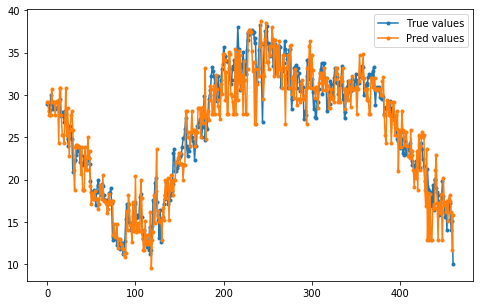

In [0]:

y_val_hat = model_unr.predict(X_val)
#print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()

Profundidad: 1
Sample Size: 2
RMSE train=  3.567413761517928
RMSE val=  3.922173970900396


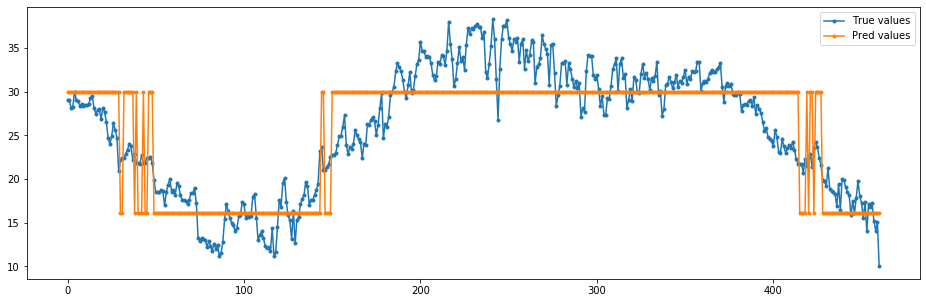

Profundidad: 1
Sample Size: 202
RMSE train=  3.567413761517928
RMSE val=  3.9221739709003964


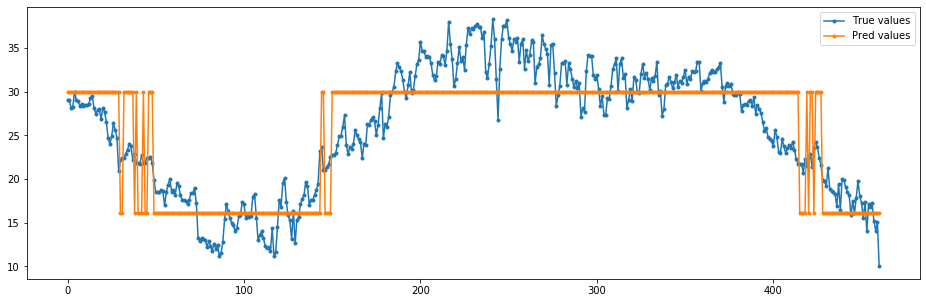

Profundidad: 1
Sample Size: 402
RMSE train=  3.567413761517928
RMSE val=  3.922173970900396


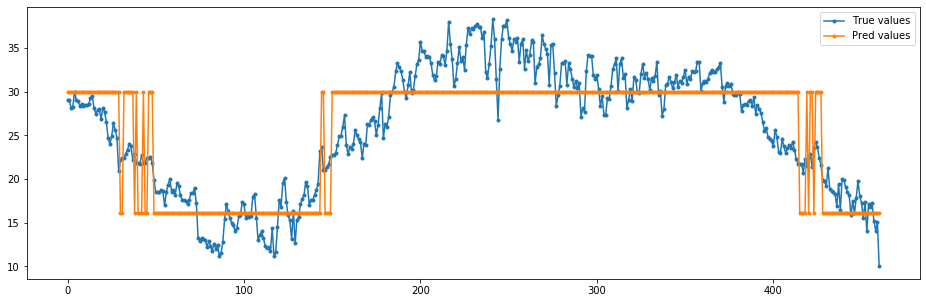

Profundidad: 1
Sample Size: 602
RMSE train=  3.567413761517928
RMSE val=  3.922173970900396


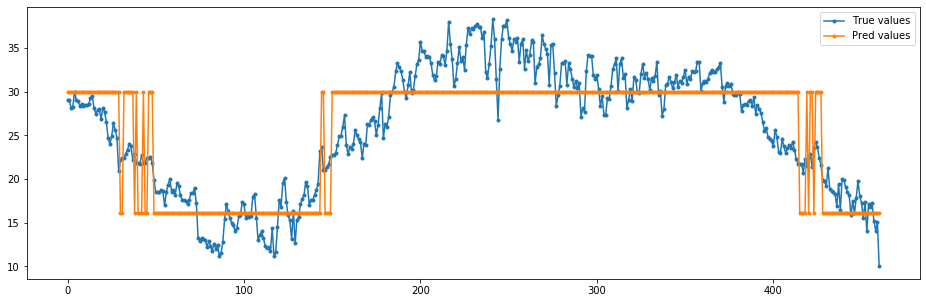

Profundidad: 1
Sample Size: 802
RMSE train=  3.567413761517928
RMSE val=  3.9221739709003964


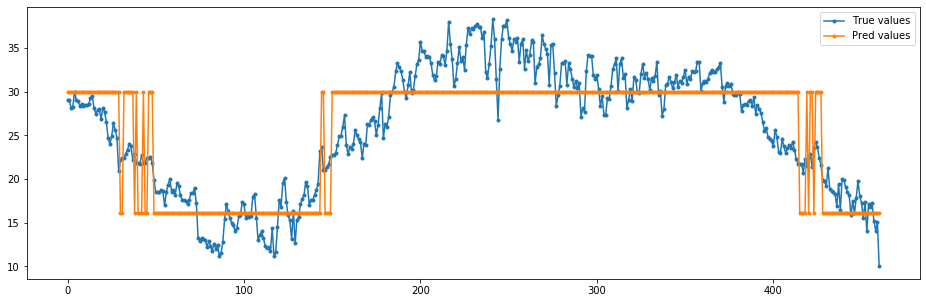

Profundidad: 3
Sample Size: 2
RMSE train=  1.8860218948939755
RMSE val=  1.8547383542194984


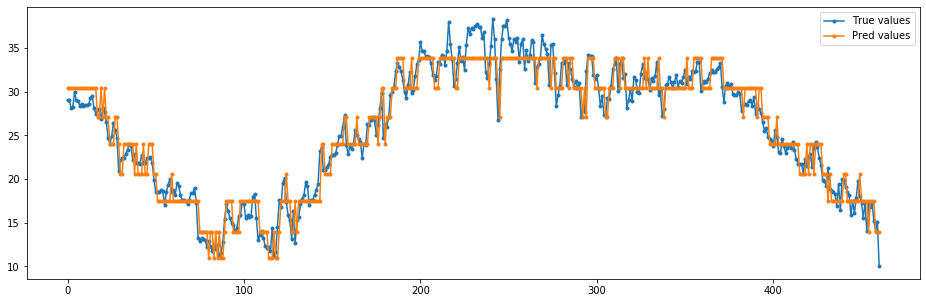

Profundidad: 3
Sample Size: 202
RMSE train=  2.1468638280736316
RMSE val=  2.138001225919572


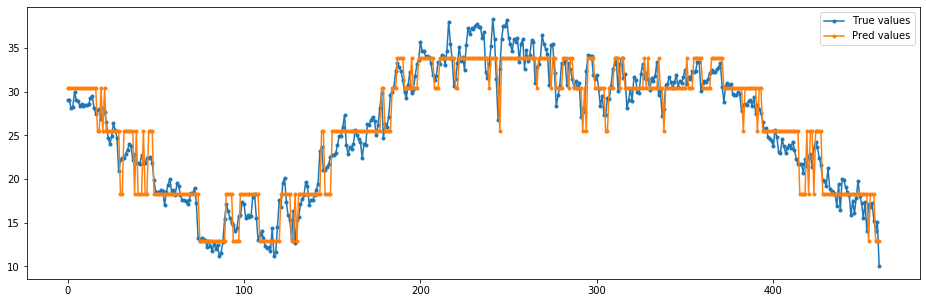

Profundidad: 3
Sample Size: 402
RMSE train=  2.6411258697150686
RMSE val=  2.5425973435457574


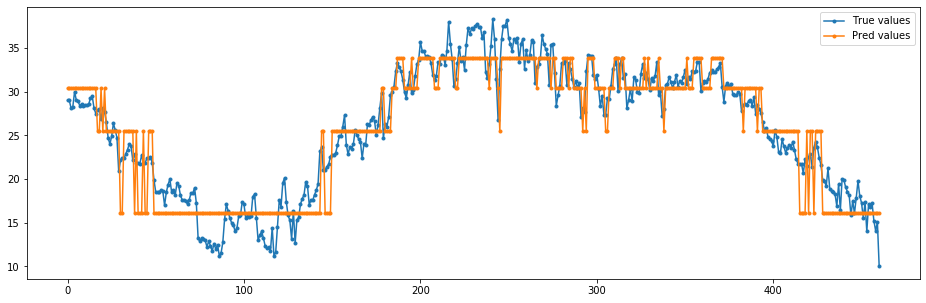

Profundidad: 3
Sample Size: 602
RMSE train=  2.8732430042395802
RMSE val=  2.8755162493817137


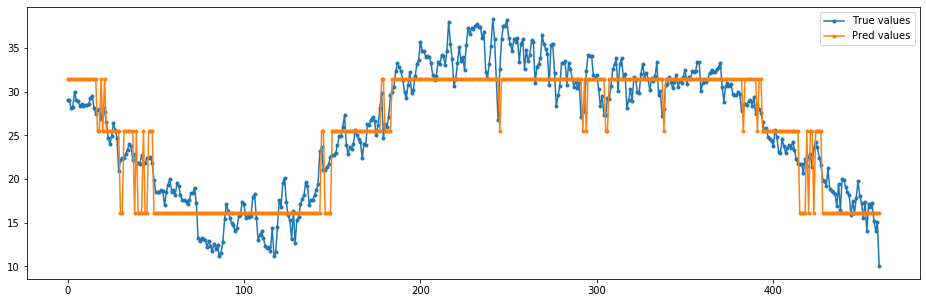

Profundidad: 3
Sample Size: 802
RMSE train=  3.567413761517928
RMSE val=  3.9221739709003964


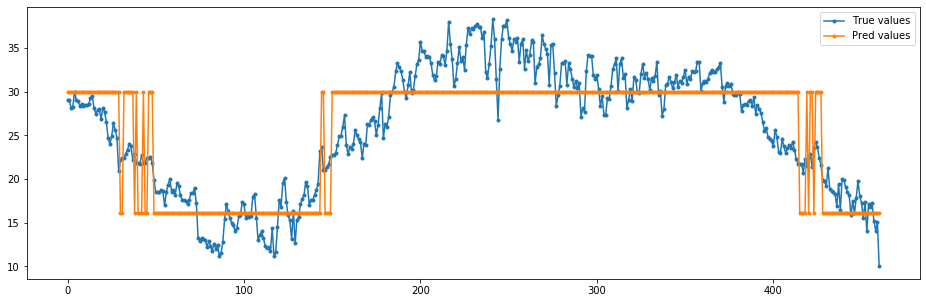

Profundidad: 5
Sample Size: 2
RMSE train=  1.5363107289102982
RMSE val=  1.7595546760583287


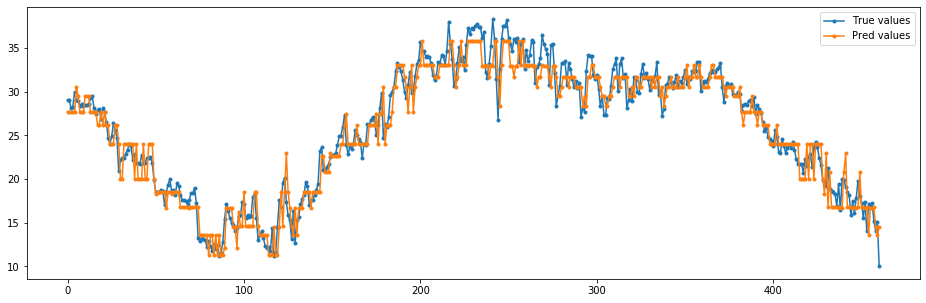

Profundidad: 5
Sample Size: 202
RMSE train=  2.0795329907238296
RMSE val=  2.0802295898361947


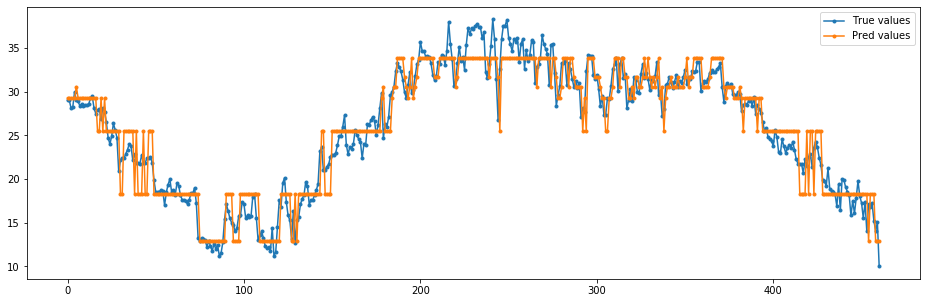

Profundidad: 5
Sample Size: 402
RMSE train=  2.6411258697150686
RMSE val=  2.542597343545756


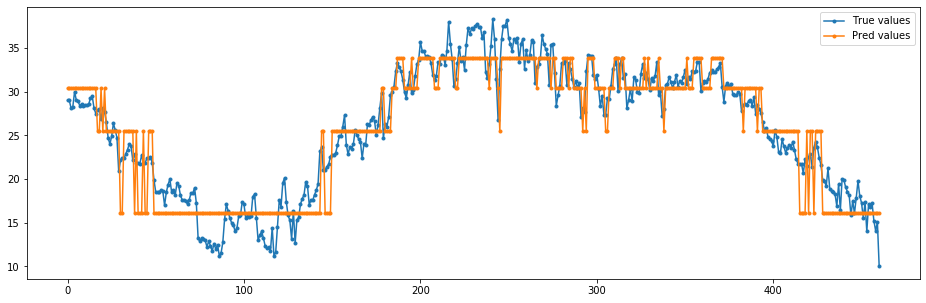

Profundidad: 5
Sample Size: 602
RMSE train=  2.8732430042395802
RMSE val=  2.8755162493817124


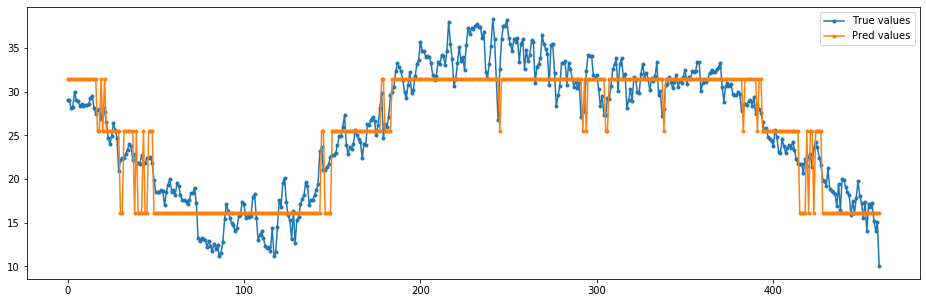

Profundidad: 5
Sample Size: 802
RMSE train=  3.567413761517928
RMSE val=  3.9221739709003955


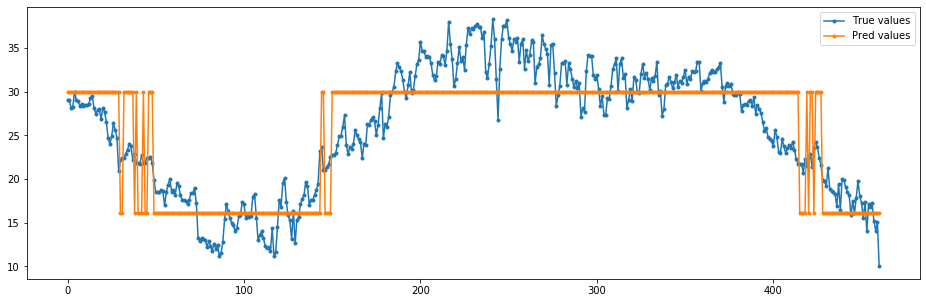

Profundidad: 7
Sample Size: 2
RMSE train=  1.278041670743795
RMSE val=  2.115841942730647


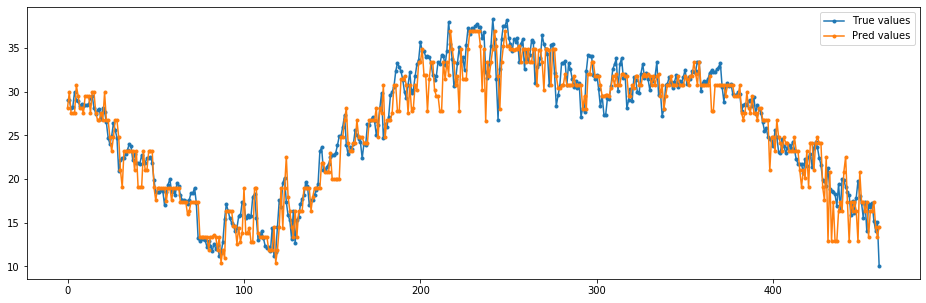

Profundidad: 7
Sample Size: 202
RMSE train=  2.0795329907238296
RMSE val=  2.0802295898361947


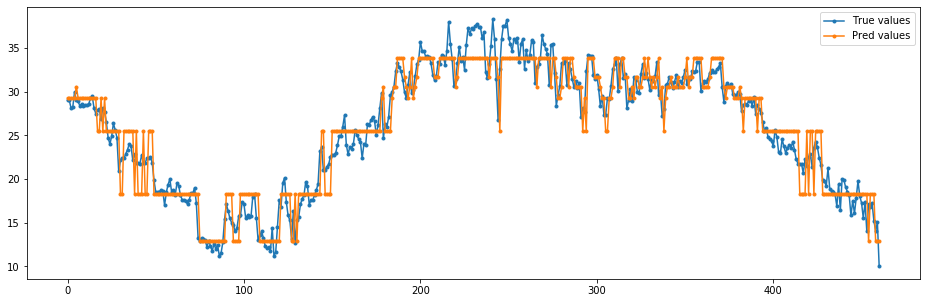

Profundidad: 7
Sample Size: 402
RMSE train=  2.6411258697150686
RMSE val=  2.542597343545755


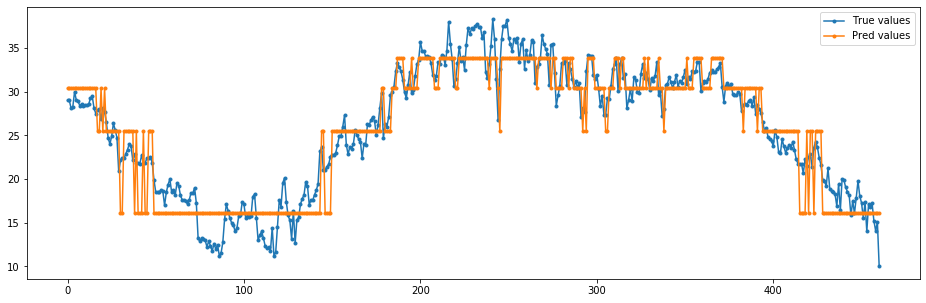

Profundidad: 7
Sample Size: 602
RMSE train=  2.8732430042395802
RMSE val=  2.875516249381712


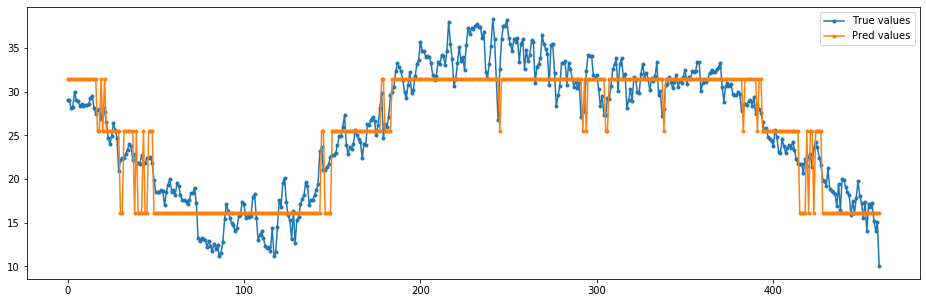

Profundidad: 7
Sample Size: 802
RMSE train=  3.567413761517928
RMSE val=  3.922173970900396


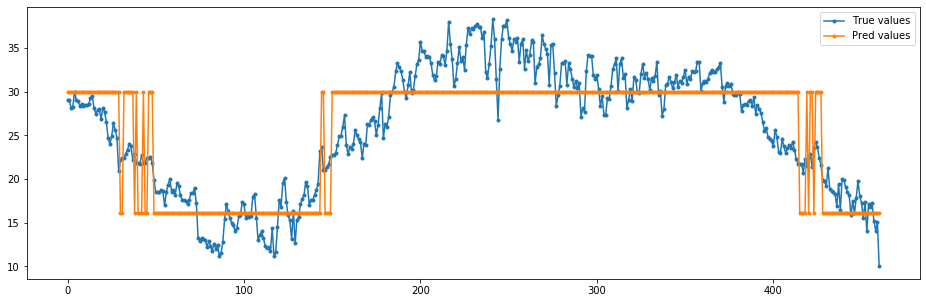

Profundidad: 9
Sample Size: 2
RMSE train=  0.9602809405376092
RMSE val=  2.2983172353381787


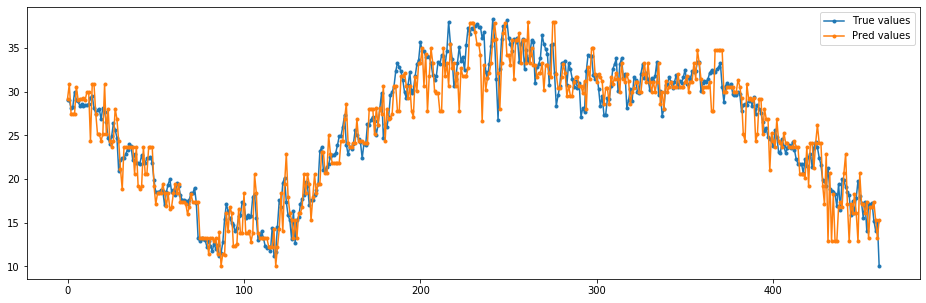

Profundidad: 9
Sample Size: 202
RMSE train=  2.0795329907238296
RMSE val=  2.080229589836194


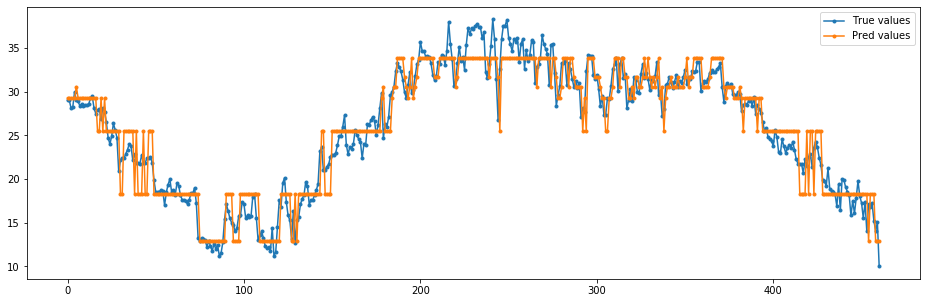

Profundidad: 9
Sample Size: 402
RMSE train=  2.641125869715068
RMSE val=  2.542597343545755


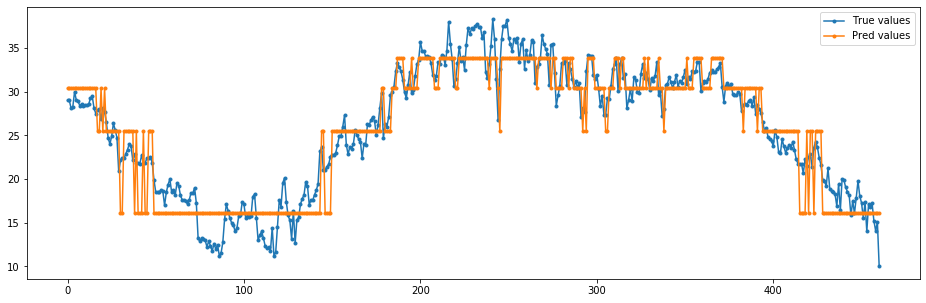

Profundidad: 9
Sample Size: 602
RMSE train=  2.8732430042395802
RMSE val=  2.875516249381713


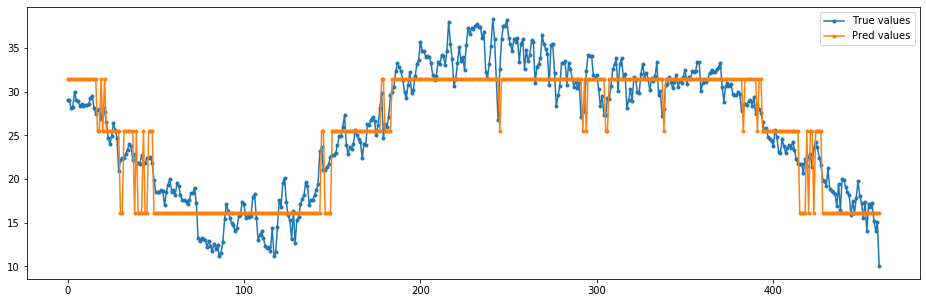

Profundidad: 9
Sample Size: 802
RMSE train=  3.567413761517928
RMSE val=  3.922173970900396


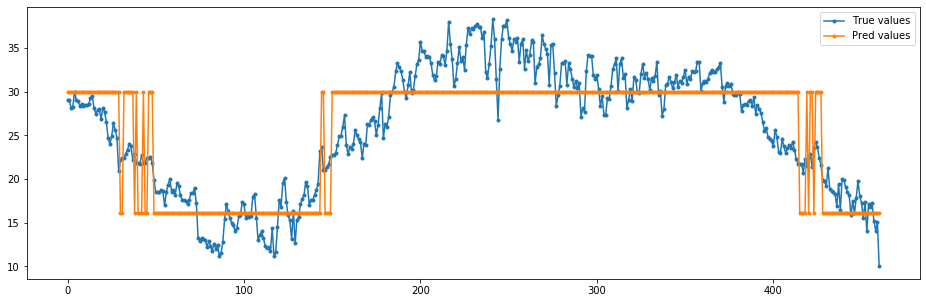

In [0]:
rmsetrain = []
rmseval = []

depth=1
sample=2
contador=0
for modelo in models:
    y_train_hat = modelo.predict(X_train)
    y_val_hat = modelo.predict(X_val)
    
    print("Profundidad: "+str(depth))
    print("Sample Size: "+str(sample))
    print("RMSE train= ",RMSE(y_train,y_train_hat))
    print("RMSE val= ",RMSE(y_val,y_val_hat))
    
    rmsetrain.append(RMSE(y_train,y_train_hat))
    rmseval.append(RMSE(y_val,y_val_hat))
    
    plt.figure(figsize=(16,5))
    
    plt.plot(y_val, '.-' ,label="True values")
    plt.plot(y_val_hat, '.-' ,label="Pred values")
    plt.legend()
    plt.show()
    contador+=1
    sample+=200
    if(contador%5==0):
      sample=2
      depth+=2

El árbol no regularizado reporta un valor RMSE de 2.59 en el conjunto de validación. 
Por otra parte se realizaron 25 permutaciones con 2 de los parámetros del árbol regularizado: profundidad y tamaño de división. La mejor configuración reportó un valor RMSE de 1.78 el cual se halló con un valor de profundidad 5 y tamaño de división 2. 
Cabe mencionar que el árbol no regularizado exhibe un mejor desempeño que 13 de los 25 árboles regularizados. Se observa una región óptima para los parámetros del árbol regularizado. Por ejemplo ninguno de los árboles con tamaño de división mayor a 402 supera en precisión al árbol no regularizado o al resto de los árboles regularizados con valores menores del mismo parámetro. Un efecto ligeramente diferente ocurre con el parámetro de profundidad al situarlo sobre 5.

d) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de Bagging, compare el Árbol no regularizado con el regularizado (seteando los hiper-parámetros en base a lo experimentado anteriormente en b)) ¿Qué debería suceder? ¿Se visualiza overfitting? Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.

Como en el caso del comité, la probabilidad que más se desvía del 50% alcanzará un valor más alto de probabilidad de éxito al formar el ensemble. Dado que el árbol regularizado reporta un mejor desempeño según su valor de RMSE, el ensemble de árboles regularizados debería lograr una menor tasa de error que el emsemble de árboles no regularizados.
 

Árbol no regularizado
N= 5
RMSE train=  0.8444887239432199
RMSE val=  1.7518868503731353
*******************************


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:1056: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


N= 25
RMSE train=  0.692248988628825
RMSE val=  1.716327341379693
*******************************
N= 45
RMSE train=  0.6666025086045063
RMSE val=  1.7173024804322303
*******************************
N= 65
RMSE train=  0.6587528459088243
RMSE val=  1.6974333060766078
*******************************
N= 85
RMSE train=  0.6548246438907506
RMSE val=  1.6991624072942098
*******************************
N= 105
RMSE train=  0.6541136820935215
RMSE val=  1.6803734151015794
*******************************
N= 125
RMSE train=  0.6466757588193295
RMSE val=  1.6874025290808619
*******************************
N= 145
RMSE train=  0.6494404629294926
RMSE val=  1.6806015829461345
*******************************
N= 165
RMSE train=  0.651916975838965
RMSE val=  1.6820232531508148
*******************************
N= 185
RMSE train=  0.6476329468955805
RMSE val=  1.6850450828371568
*******************************
N= 205
RMSE train=  0.6400104152923937
RMSE val=  1.6880351717490947
*****************************

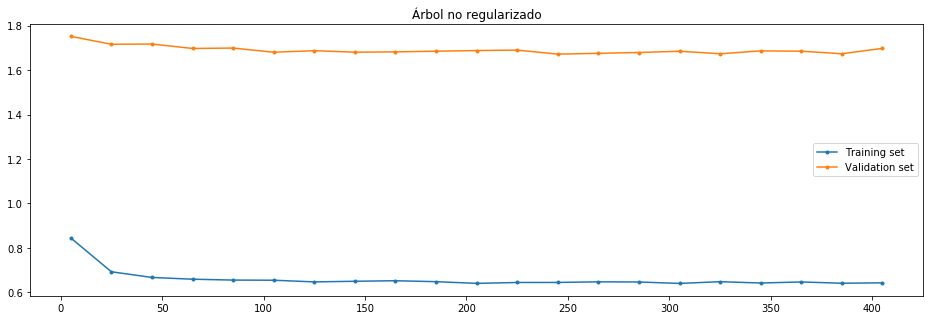

In [0]:
from sklearn.ensemble import BaggingRegressor

n = np.arange(5, 420,20)
bagging_no_regularizado=[]
print("Árbol no regularizado") 
no_regularizado_train=[]
no_regularizado_val=[]
for i in n:
  model = BaggingRegressor(base_estimator=Tree(), n_estimators=i, n_jobs=-1,oob_score=True)
  model.fit(X_train,y_train)
  bagging_no_regularizado.append((model,i))
  y_train_hat = model.predict(X_train)
  y_val_hat = model.predict(X_val)
  RMSE_t = RMSE(y_train,y_train_hat)
  RMSE_v = RMSE(y_val,y_val_hat)
  no_regularizado_train.append(RMSE_t)
  no_regularizado_val.append(RMSE_v)
  print("N= " +str(i))
  print("RMSE train= ",RMSE_t)
  print("RMSE val= ",RMSE_v)
  print("*******************************")


plt.figure(figsize=(16,5))
plt.plot(n,no_regularizado_train, '.-' ,label="Training set")
plt.plot(n,no_regularizado_val, '.-' ,label="Validation set")
plt.title("Árbol no regularizado")
plt.legend()
plt.show()




Mejor desempeño ensemble no regularizado: N=245

*   N          =  205
*   RMSE train =  0.64
*   RMSE val   =  1.67


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:1056: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


N= 5
RMSE train=  1.478728572892538
RMSE val=  1.6635073359284462
*******************************
N= 25
RMSE train=  1.447314145360981
RMSE val=  1.553382418379845
*******************************
N= 45
RMSE train=  1.4443220365713862
RMSE val=  1.5755897451616885
*******************************
N= 65
RMSE train=  1.443462058167089
RMSE val=  1.550010895059799
*******************************
N= 85
RMSE train=  1.4399389385015926
RMSE val=  1.5602590122838835
*******************************
N= 105
RMSE train=  1.4409473274684812
RMSE val=  1.555144230628934
*******************************
N= 125
RMSE train=  1.4400910573334322
RMSE val=  1.549126750435656
*******************************
N= 145
RMSE train=  1.4404931022080567
RMSE val=  1.5570240345059814
*******************************
N= 165
RMSE train=  1.437660229413478
RMSE val=  1.5541443319522597
*******************************
N= 185
RMSE train=  1.4414856083662009
RMSE val=  1.54168947720677
*******************************
N= 205

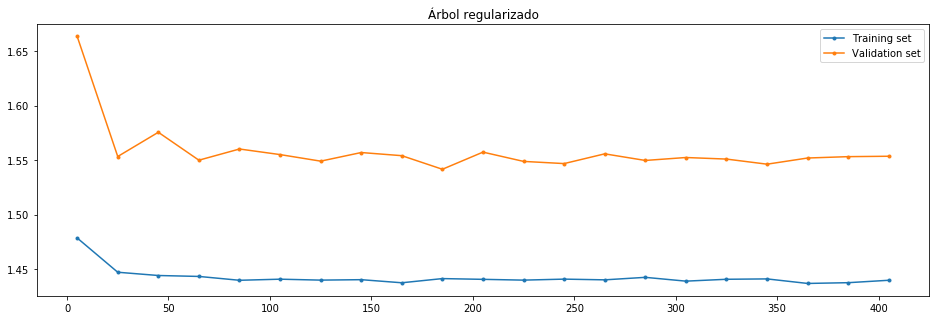

In [0]:
regularizado_train=[]
regularizado_val=[]
n = np.arange(5, 420,20)
for i in n:
  model = BaggingRegressor(base_estimator=Tree(max_depth = 5, min_samples_split = 2), n_estimators=i, n_jobs=-1,oob_score=True)
  model.fit(X_train,y_train)
  y_train_hat = model.predict(X_train)
  y_val_hat = model.predict(X_val)
  RMSE_t = RMSE(y_train,y_train_hat)
  RMSE_v = RMSE(y_val,y_val_hat)
  regularizado_train.append(RMSE_t)
  regularizado_val.append(RMSE_v)
  print("N= " +str(i))
  print("RMSE train= ",RMSE_t)
  print("RMSE val= ",RMSE_v)
  print("*******************************")


import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
plt.plot(n,regularizado_train, '.-' ,label="Training set")
plt.plot(n,regularizado_val, '.-' ,label="Validation set")
plt.title("Árbol regularizado")
plt.legend()
plt.show()


Mejor desempeño ensemble regularizado:

*   N          =  205
*   RMSE train =  1.44
*   RMSE val   =  1.55

La diferencia entre los valores de RMSE para el ensemble de árboles no regularizados es cercana a 1. Para el caso de los ensembles regularizados es cercana a 0.1. Existe una discrepancia de 1 orden de magnitud, lo que sugiere la suceptibilidad al overfitting del primer ensemble en comparación al segundo. Por su parte los gráficos también permiten notar esta tendencia. Aún más, se advierte que luego del primer incremento desde N = 5 a N = 25, la tasa de error sobre el conjunto de validación disminuye en mayor medida que su análogo de entrenamiento, por lo que el modelo mejora su tendencia al overfitting al aumentar el hiper parámetro N.





e) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de AdaBoost, compare el Árbol no regularizado con el regularizado (seteando los hiper-parámetros en base a lo experimentado anteriormente en d) ¿Se visualiza overfitting? ¿Qué técnica utiliza la librería de sklearn, re-muestrear o pesar ejemplos? ¿Qué le parece más sensato?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro. Compare y analice con la técnica utilizada en d).

Árbol no regularizado
N = 5
RMSE train =  0.39115203844593965
RMSE val =  1.9463090229973612
*******************************
N = 25
RMSE train =  0.09214636390521537
RMSE val =  1.8896518731842262
*******************************
N = 45
RMSE train =  0.06148350257130249
RMSE val =  1.7734080167310036
*******************************
N = 65
RMSE train =  0.07352262790501277
RMSE val =  1.7407490666932506
*******************************
N = 85
RMSE train =  0.0690235795590709
RMSE val =  1.7500626836296502
*******************************
N = 105
RMSE train =  0.0769320771923766
RMSE val =  1.7259174615167499
*******************************
N = 125
RMSE train =  0.06107417843990085
RMSE val =  1.7315730424814615
*******************************
N = 145
RMSE train =  0.06713310466153496
RMSE val =  1.7086954920064708
*******************************
N = 165
RMSE train =  0.0715019365292832
RMSE val =  1.7081611474666678
*******************************
N = 185
RMSE train =  0.06972171969536405


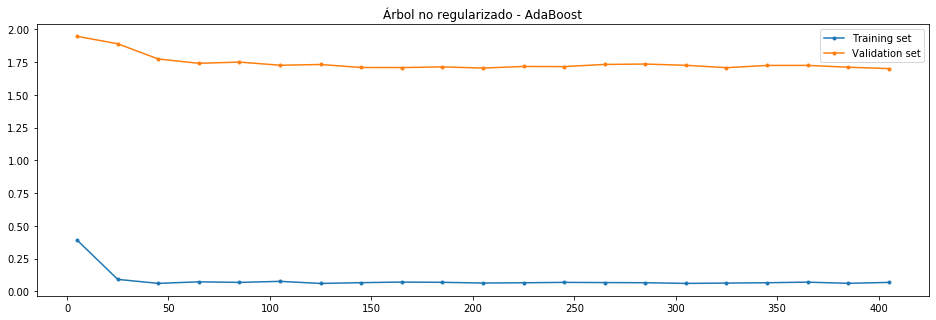

In [0]:
from sklearn.ensemble import AdaBoostRegressor

no_regularizado_train=[]
no_regularizado_val=[]
print("Árbol no regularizado")
n = np.arange(5, 420,20) 
for i in n:
  model = AdaBoostRegressor(base_estimator=Tree(), n_estimators=i)
  model.fit(X_train,y_train)
  y_train_hat = model.predict(X_train)
  y_val_hat = model.predict(X_val)
  RMSE_t = RMSE(y_train,y_train_hat)
  RMSE_v = RMSE(y_val,y_val_hat)
  no_regularizado_train.append(RMSE_t)
  no_regularizado_val.append(RMSE_v)
  print("N = " +str(i))
  print("RMSE train = ",RMSE_t)
  print("RMSE val = ",RMSE_v)
  print("*******************************")


plt.figure(figsize=(16,5))
plt.plot(n,no_regularizado_train, '.-' ,label="Training set")
plt.plot(n,no_regularizado_val, '.-' ,label="Validation set")
plt.title("Árbol no regularizado - AdaBoost")
plt.legend()
plt.show()


N = 5
RMSE train =  1.4556486394773434
RMSE val =  1.7297455814925207
*******************************
N = 25
RMSE train =  1.3669516803769663
RMSE val =  1.6765627390682147
*******************************
N = 45
RMSE train =  1.363599059647606
RMSE val =  1.7077530269482812
*******************************
N = 65
RMSE train =  1.338102383287882
RMSE val =  1.7269778005701513
*******************************
N = 85
RMSE train =  1.3398517074803058
RMSE val =  1.7268257810652605
*******************************
N = 105
RMSE train =  1.3418377787049558
RMSE val =  1.730522712048906
*******************************
N = 125
RMSE train =  1.319457914449027
RMSE val =  1.7333459125690032
*******************************
N = 145
RMSE train =  1.3287725667211192
RMSE val =  1.7411370853995318
*******************************
N = 165
RMSE train =  1.326187657004403
RMSE val =  1.7612601929558673
*******************************
N = 185
RMSE train =  1.323917395577859
RMSE val =  1.7376682806633674
****

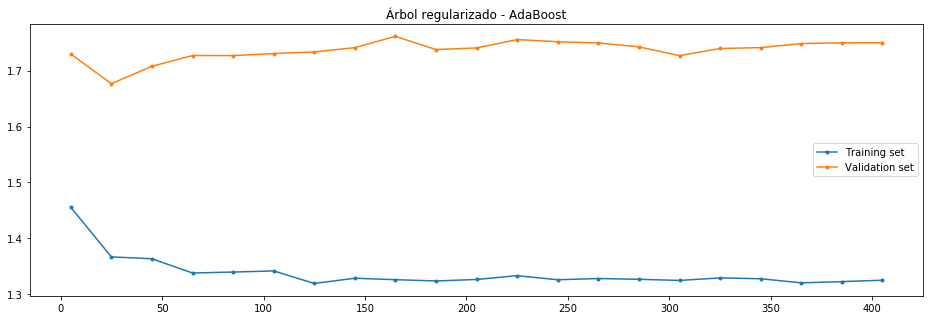

In [0]:
regularizado_train=[]
regularizado_val=[]
for i in n:
  model = AdaBoostRegressor(base_estimator=Tree(max_depth = 5, min_samples_split = 2), n_estimators=i)
  model.fit(X_train,y_train)
  y_train_hat = model.predict(X_train)
  y_val_hat = model.predict(X_val)
  RMSE_t = RMSE(y_train,y_train_hat)
  RMSE_v = RMSE(y_val,y_val_hat)
  regularizado_train.append(RMSE_t)
  regularizado_val.append(RMSE_v)
  print("N = " +str(i))
  print("RMSE train = ",RMSE_t)
  print("RMSE val = ",RMSE_v)
  print("*******************************")


plt.figure(figsize=(16,5))
plt.plot(n,regularizado_train, '.-' ,label="Training set")
plt.plot(n,regularizado_val, '.-' ,label="Validation set")
plt.title("Árbol regularizado - AdaBoost")
plt.legend()
plt.show()


AdaBoost emplea un método que involucra resampling y cambio de peso de los ejemplos. Los ejemplos que cierto regresor predice erróneamente son asignados mayor peso lo que hace más probable que sean seleccionados para el siguiente muestreo.

La técnica de AdaBoost parece más consistente que remuestreo solo por sí mismo, pues enfoca el entrenamiento sobre los casos menos evidentes para el modelo.

El ensemble árbol no regularizado presenta un mayor grado de overfitting que su análogo entrenado sin AdaBoost, y su tasa de error sobre el conjunto de validación también es mayor.

Para el caso del árbol regularizado, el grado de overfitting disminuye, pero su tasa de error sobre el conjunto de validación es ligeramente mayor para la instancia entrenada con AdaBoost. El ensemble de árboles regularizados del inciso d presentan un mejor desempeño.

f) Pruebe otra técnica de ensamblado dedicada a árboles de decisión, que combina el muestreo boostrap de Bagging con muestreo sobre las features: Random Forest, compare el Árbol no regularizado con el regularizado ¿Se visualiza overfitting?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (n estimators), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.



Árbol no regularizado


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


N = 5
RMSE train =  0.8834435957860954
RMSE val =  1.7642474782923507
*******************************
N = 25
RMSE train =  0.6809331391223029
RMSE val =  1.6883850655761217
*******************************
N = 45
RMSE train =  0.6782783055480649
RMSE val =  1.6436037292783077
*******************************
N = 65
RMSE train =  0.6661694038350406
RMSE val =  1.6946235005023682
*******************************
N = 85
RMSE train =  0.6609813176845566
RMSE val =  1.706832101654424
*******************************
N = 105
RMSE train =  0.6548688681831666
RMSE val =  1.6969961490979448
*******************************
N = 125
RMSE train =  0.6554552237313501
RMSE val =  1.7025627363986118
*******************************
N = 145
RMSE train =  0.6536870068215577
RMSE val =  1.6757106578996548
*******************************
N = 165
RMSE train =  0.646346107177215
RMSE val =  1.6606494179763718
*******************************
N = 185
RMSE train =  0.6525265928431212
RMSE val =  1.6764444377059966


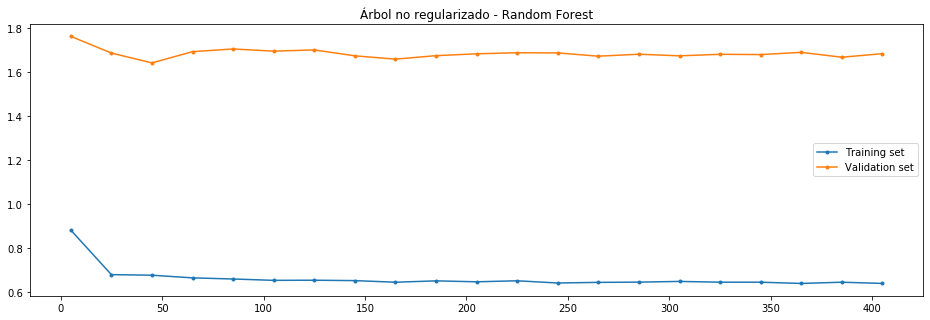

In [0]:
from sklearn.ensemble import RandomForestRegressor

no_regularizado_train=[]
no_regularizado_val=[]
print("Árbol no regularizado")
for i in n:
  model = RandomForestRegressor(n_estimators=i, n_jobs=-1,oob_score=True)
  model.fit(X_train,y_train)
  y_train_hat = model.predict(X_train)
  y_val_hat = model.predict(X_val)
  RMSE_t = RMSE(y_train,y_train_hat)
  RMSE_v = RMSE(y_val,y_val_hat)
  no_regularizado_train.append(RMSE_t)
  no_regularizado_val.append(RMSE_v)
  print("N = " +str(i))
  print("RMSE train = ",RMSE_t)
  print("RMSE val = ",RMSE_v)
  print("*******************************")


plt.figure(figsize=(16,5))
plt.plot(n,no_regularizado_train, '.-' ,label="Training set")
plt.plot(n,no_regularizado_val, '.-' ,label="Validation set")
plt.title("Árbol no regularizado - Random Forest")
plt.legend()
plt.show()


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


N = 5
RMSE train =  1.4790494597075128
RMSE val =  1.6380993250164262
*******************************
N = 25
RMSE train =  1.4408296615909981
RMSE val =  1.5595666694617316
*******************************
N = 45
RMSE train =  1.448406332913186
RMSE val =  1.5560476561100485
*******************************
N = 65
RMSE train =  1.4480795067156513
RMSE val =  1.5433203919902145
*******************************
N = 85
RMSE train =  1.437928323818814
RMSE val =  1.554077866601869
*******************************
N = 105
RMSE train =  1.4357229769895106
RMSE val =  1.566306660135658
*******************************
N = 125
RMSE train =  1.4387431669036614
RMSE val =  1.5533345231914126
*******************************
N = 145
RMSE train =  1.4427572479502202
RMSE val =  1.5488373259721404
*******************************
N = 165
RMSE train =  1.4405750298460556
RMSE val =  1.5539986444676737
*******************************
N = 185
RMSE train =  1.4421312418303691
RMSE val =  1.5461330195873735
**

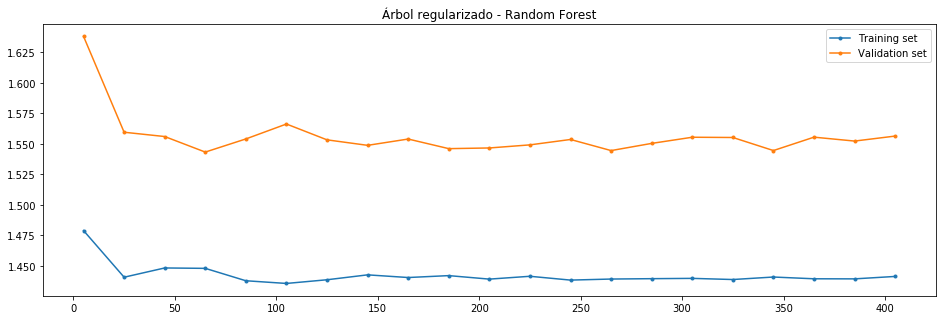

In [0]:
regularizado_train=[]
regularizado_val=[]
randomforest_regularizado=[]
for i in n:
  model = RandomForestRegressor(n_estimators=i, n_jobs=-1,max_depth = 5, min_samples_split = 2,oob_score=True)
  model.fit(X_train,y_train)
  randomforest_regularizado.append((model,i))
  y_train_hat = model.predict(X_train)
  y_val_hat = model.predict(X_val)
  RMSE_t = RMSE(y_train,y_train_hat)
  RMSE_v = RMSE(y_val,y_val_hat)
  regularizado_train.append(RMSE_t)
  regularizado_val.append(RMSE_v)
  print("N = " +str(i))
  print("RMSE train = ",RMSE_t)
  print("RMSE val = ",RMSE_v)
  print("*******************************")


plt.figure(figsize=(16,5))
plt.plot(n,regularizado_train, '.-' ,label="Training set")
plt.plot(n,regularizado_val, '.-' ,label="Validation set")
plt.title("Árbol regularizado - Random Forest")
plt.legend()
plt.show()

Mejor desempeño: Bosque Árbol regularizado
*   N          =  245
*   RMSE train =  1.43
*   RMSE val   =  1.56

Se reitera el patrón observado hasta este punto. El bosque de árboles no regularizados tiene un desempeño inferior. El bosque de árboles regularizados entrenado presenta el mejor modelo observado hasta ahora con un RMSE de 1.43 sobre el conjunto de validación.


g) Verifique que el OOB error (out of bag error) de los ensambladores que utilizan la técnica boostrap puede ser una alternativa como métrica de generalización, compare con el error calculado sobre el conjunto de validación (o en su defecto cross validation).

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:1056: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


N= 5
OOB = 0.945336741282396
RMSE val=  1.7724057432869098
*******************************
N= 25
OOB = 0.945336741282396
RMSE val=  1.7353673614827076
*******************************
N= 45
OOB = 0.945336741282396
RMSE val=  1.7027816594402205
*******************************
N= 65
OOB = 0.945336741282396
RMSE val=  1.6935547357402625
*******************************
N= 85
OOB = 0.945336741282396
RMSE val=  1.6902694273408696
*******************************
N= 105
OOB = 0.945336741282396
RMSE val=  1.673362173647863
*******************************
N= 125
OOB = 0.945336741282396
RMSE val=  1.674462625897047
*******************************
N= 145
OOB = 0.945336741282396
RMSE val=  1.6931268987453612
*******************************
N= 165
OOB = 0.945336741282396
RMSE val=  1.686144698025318
*******************************
N= 185
OOB = 0.945336741282396
RMSE val=  1.6828157249504154
*******************************
N= 205
OOB = 0.945336741282396
RMSE val=  1.6786093940729019
******************

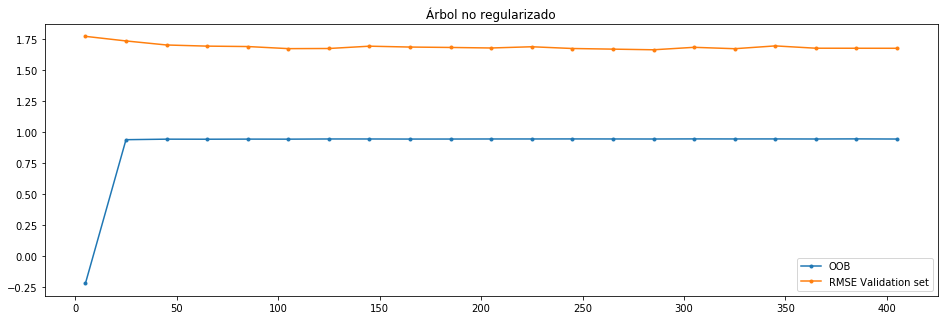

In [0]:
no_regularizado_val=[]
error_oob=[]
n = np.arange(5, 420,20)
for i in n:

  model = BaggingRegressor(base_estimator=Tree(), n_estimators=i, n_jobs=-1,oob_score=True)
  model.fit(X_train,y_train)
  error_oob.append(model.oob_score_)

  #bagging_no_regularizado.append((model,i))

  y_val_hat = model.predict(X_val)
  RMSE_v = RMSE(y_val,y_val_hat)
  no_regularizado_val.append(RMSE_v)
  

  print("N= " +str(i))
  print("OOB = "+str(oob_error))
  print("RMSE val= ",RMSE_v)
  print("*******************************")


print(len(n))
print(len(error_oob))
plt.figure(figsize=(16,5))
plt.plot(n,error_oob, '.-' ,label="OOB")
plt.plot(n,no_regularizado_val, '.-' ,label="RMSE Validation set")
plt.title("Árbol no regularizado")
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:1056: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


N = 5
OOB = -0.2817958244626171
RMSE val =  1.6661415968980728
*******************************
N = 25
OOB = 0.9453953899265556
RMSE val =  1.5515611278227008
*******************************
N = 45
OOB = 0.9464798873279018
RMSE val =  1.5540205557397837
*******************************
N = 65
OOB = 0.9467182755107052
RMSE val =  1.5547165488924888
*******************************
N = 85
OOB = 0.9473630051311339
RMSE val =  1.5619098371728506
*******************************
N = 105
OOB = 0.9469540692959568
RMSE val =  1.5478192909598705
*******************************
N = 125
OOB = 0.9472479130841011
RMSE val =  1.5656982198243696
*******************************
N = 145
OOB = 0.9471925192371455
RMSE val =  1.5621652123403138
*******************************
N = 165
OOB = 0.9465294514690081
RMSE val =  1.5494111830624502
*******************************
N = 185
OOB = 0.9471920797771307
RMSE val =  1.5637730494321223
*******************************
N = 205
OOB = 0.9471427768775429
RMSE val =  

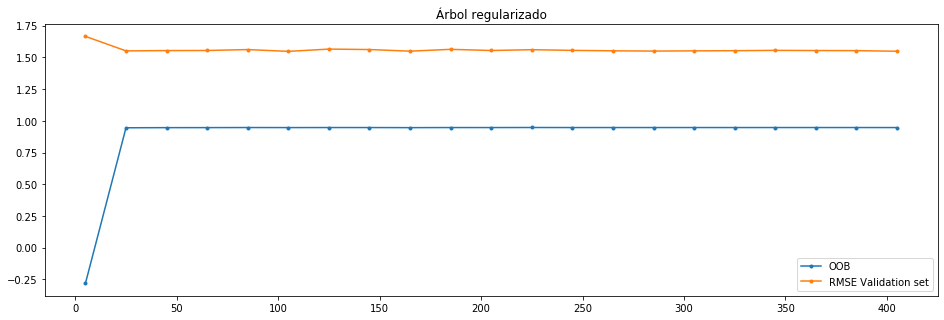

In [0]:
regularizado_val=[]
error_oob=[]
indice = 0
n = np.arange(5, 420,20)
for i in n:

  model = BaggingRegressor(base_estimator=Tree(max_depth = 5, min_samples_split = 2), n_estimators=i, n_jobs=-1,oob_score=True)
  model.fit(X_train,y_train)
  error_oob.append(model.oob_score_)
  #bagging_no_regularizado.append((model,i))

  y_val_hat = model.predict(X_val)
  RMSE_v = RMSE(y_val,y_val_hat)
  regularizado_val.append(RMSE_v)
  

  print("N = " +str(i))
  print("OOB = "+str(error_oob[indice]))
  indice+=1
  print("RMSE val = ",RMSE_v)
  print("*******************************")


plt.figure(figsize=(16,5))
plt.plot(n,error_oob, '.-' ,label="OOB")
plt.plot(n,regularizado_val, '.-' ,label="RMSE Validation set")
plt.title("Árbol regularizado")
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


N = 5
OOB = -0.3691312374184592
RMSE val =  1.9122522643002937
*******************************
N = 25
OOB = 0.9399331867109588
RMSE val =  1.7038056837184214
*******************************
N = 45
OOB = 0.9423468133685816
RMSE val =  1.677755310998314
*******************************
N = 65
OOB = 0.9439508946918619
RMSE val =  1.656360520479926
*******************************
N = 85
OOB = 0.9436227123826434
RMSE val =  1.7054050620334182
*******************************
N = 105
OOB = 0.9446078389036702
RMSE val =  1.7008012017828353
*******************************
N = 125
OOB = 0.943303142789703
RMSE val =  1.687085820110207
*******************************
N = 145
OOB = 0.9443415956586569
RMSE val =  1.690524851156659
*******************************
N = 165
OOB = 0.9449861856531929
RMSE val =  1.6859192914709904
*******************************
N = 185
OOB = 0.944367541393973
RMSE val =  1.6934041659611654
*******************************
N = 205
OOB = 0.9441741064154069
RMSE val =  1.6943

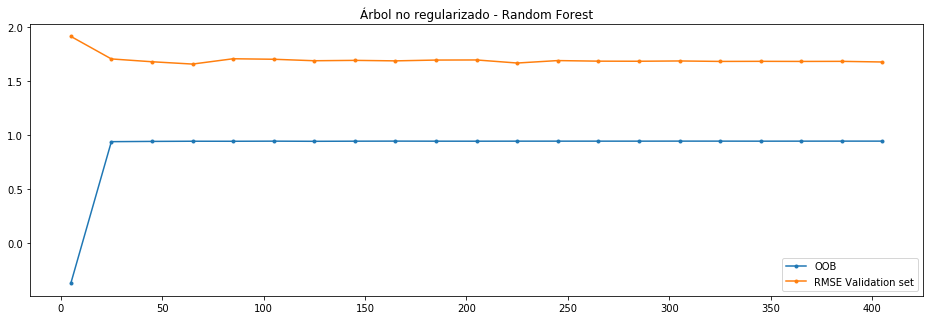

In [0]:
no_regularizado_val=[]
error_oob = []
indice = 0
for i in n:
  model = RandomForestRegressor(n_estimators=i, n_jobs=-1,oob_score=True)
  model.fit(X_train,y_train)

  error_oob.append(model.oob_score_)

  y_val_hat = model.predict(X_val)
  RMSE_v = RMSE(y_val,y_val_hat)
  no_regularizado_val.append(RMSE_v)

  print("N = " +str(i))
  print("OOB = "+str(error_oob[indice]))
  indice+=1
  print("RMSE val = ",RMSE_v)
  print("*******************************")

plt.figure(figsize=(16,5))
plt.plot(n,error_oob, '.-' ,label="OOB")
plt.plot(n,no_regularizado_val, '.-' ,label="RMSE Validation set")
plt.title("Árbol no regularizado - Random Forest")
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


N = 5
OOB = -0.23838709993394813
RMSE val =  1.6745757288753587
*******************************
N = 25
OOB = 0.9455239193486226
RMSE val =  1.5478541533768153
*******************************
N = 45
OOB = 0.9458782988629828
RMSE val =  1.56052104455409
*******************************
N = 65
OOB = 0.9467841443426009
RMSE val =  1.5563637123228735
*******************************
N = 85
OOB = 0.9462590945606062
RMSE val =  1.566647952457905
*******************************
N = 105
OOB = 0.9470782817027583
RMSE val =  1.5485843045843513
*******************************
N = 125
OOB = 0.9467962295730518
RMSE val =  1.5634662780739461
*******************************
N = 145
OOB = 0.9471557749589588
RMSE val =  1.5478524155762163
*******************************
N = 165
OOB = 0.9472898961215968
RMSE val =  1.5537352139860146
*******************************
N = 185
OOB = 0.9472062098058818
RMSE val =  1.5591291197185912
*******************************
N = 205
OOB = 0.9471855817600383
RMSE val =  1.

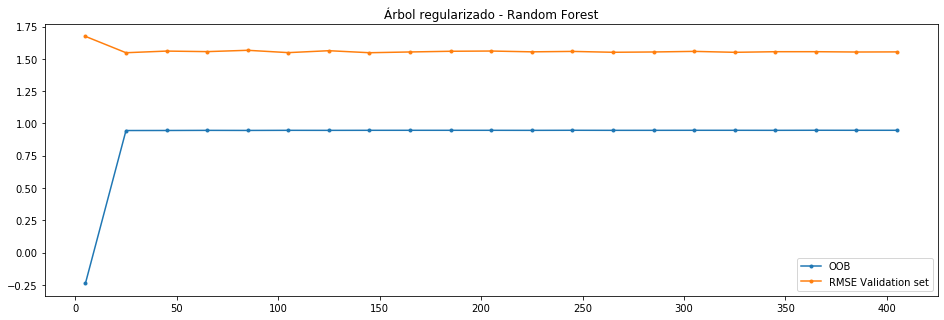

In [0]:
regularizado_val=[]
error_oob = []
indice = 0
modelos=[]
for i in n:
  model = RandomForestRegressor(n_estimators=i, n_jobs=-1,max_depth = 5, min_samples_split = 2,oob_score=True)
  model.fit(X_train,y_train)
  modelos.append(model)

  error_oob.append(model.oob_score_)

  y_val_hat = model.predict(X_val)
  RMSE_v = RMSE(y_val,y_val_hat)
  regularizado_val.append(RMSE_v)

  print("N = " +str(i))
  print("OOB = "+str(error_oob[indice]))
  indice+=1
  print("RMSE val = ",RMSE_v)
  print("*******************************")

plt.figure(figsize=(16,5))
plt.plot(n,error_oob, '.-' ,label="OOB")
plt.plot(n,regularizado_val, '.-' ,label="RMSE Validation set")
plt.title("Árbol regularizado - Random Forest")
plt.legend()
plt.show()

h) Defina otra forma de combinar los valores que entregan los ensamblados al hacer predicciones y compare con lo que se hace actualmente, por ejemplo Bagging realiza el voto de la mayoría para clasificación y promedio para regresión, AdaBoost realiza una combinación ponderada de cada clasificador dependiendo de su habilidad (desempeño para clasificar el conjunto de entrenamiento). Se puede inspirar desde clásicos estadísticos, como entregar el primer cuartíl (Q1) si al ensamblado le cuesta predecir valores bajos, o el segundo cuartil (Q2) o mediana para ser robusto a predicciones atípicas de modelos. 

In [0]:
def combine_predictions(predictions):
    #print(len(predictions))
    #print(len(y_val))
    q1 = np.quantile(predictions,.25)
    q2 = np.quantile(predictions,.5)
    q3 = np.quantile(predictions,.75)
    diferencia1 = abs(q1-y_val)
    diferencia2 = abs(q2-y_val)
    diferencia3 = abs(q3-y_val)
    #if diferencia1<diferencia2:
     # if diferencia1<diferencia3:
      #  return q1
    #elif diferencia2<diferencia3:
     # return q2
    #return q3

for mod in modelos:
  list_estimators = mod.estimators_
  list_predictions = [estimator.predict(X_val) for estimator in list_estimators]
  new_predictions = combine_predictions(list_predictions)
  #print("RMSE val= ",RMSE(y_val, new_predictions))



i) Si se cuenta con una gran cantidad de modelos en el ensamblado, por ejemplo T>100, se puede crear un intervalo de confianza de la predicción a través de todos estos valores, asumiendo una distribución Normal centrada en la media muestral de las predicciones, con desviación estándar muestral en las predicciones. El intervalo de confianza entrega más información que un único valor puntual de predicción. Visualice un intervalo de confianza al 95% de probabilidad en la predicción a lo largo de la serie de tiempo de validación, comente. Al asumir una distribución Normal, también puede explorar el tomar como predicción del ensamblado el muestreo sobre la distribución Normal creada entorno a los datos muestrales.

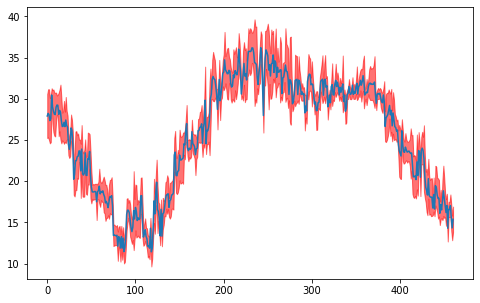

In [0]:
list_estimators = model.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]
#new_predictions = combine_predictions(list_predictions)
#print("RMSE val= ",RMSE(y_val, new_predictions))

X_val_est = np.vstack(list_predictions).T #has shape=(N_test, n_estimator), with n_estimator>100
from scipy.stats import norm
interv_val = []
for n in range(X_val.shape[0]):
    low, up = norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    interv_val.append([low,up])
interv_val = np.asarray(interv_val)
x = np.arange(X_val_est.shape[0])
plt.figure(figsize=(8,5))
plt.plot(x, np.mean(X_val_est, axis=1))
plt.fill_between(x, interv_val[:,0], interv_val[:,1], color='r', alpha=.55)
plt.show()

La pregunta 2 se subió a la plataforma Kaggle (equipo: "NPino-GLarrain").